<a href="https://colab.research.google.com/github/ThunderWiring/learning-computer-vision/blob/main/Histogram_of_oriented_gradients_(HoG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histogram of oriented gradients - HoG

HoG is a feature extraction method.

The output for this section is a function that receives an image and produces a feature descriptor vector that will be used in a later section for image  classification purpose.

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

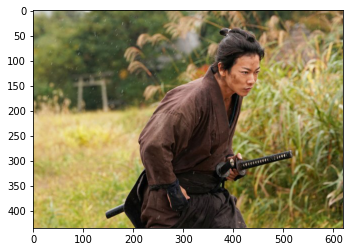

In [107]:
img_url = 'https://cineuropa.org/imgCache/2019/06/26/1561540847432_0620x0435_0x0x0x0_1573335839350.jpg'
image = io.imread(img_url) 
plt.figure()
plt.imshow(image)

i will be working with the image above in order to demonstrate and implement HoG stages.

In [108]:
image_tensor = torch.from_numpy(image)
image_tensor.shape

torch.Size([435, 620, 3])

According to the original paper, the HoG input image must have a ration of 2:1 (has 2x rows than cols). The following function does this reshape, it uses pytorch transform function `interpolate`

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


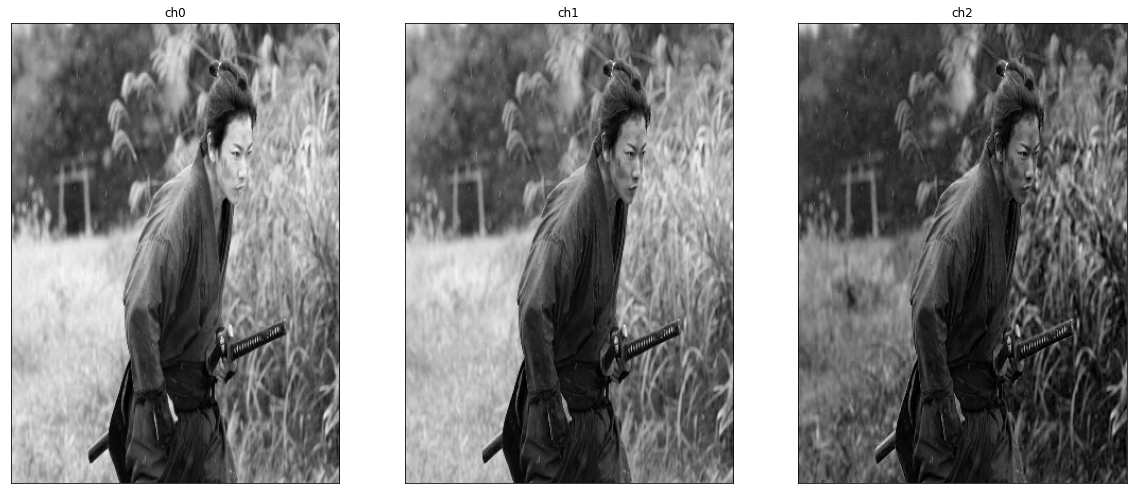

In [109]:
def pre_process(img_tensor):
  # shape = (C, H, W)
  rows = img_tensor.shape[1]
  cols = img_tensor.shape[2]
  return img_tensor if rows == 2 * cols else F.interpolate(img_tensor, scale_factor=(0.5, 1))

proc_tensor = pre_process(image_tensor.unsqueeze(0))

channels = [proc_tensor[:,:,:,c] for c in range(3)]
titles=['ch0', 'ch1', 'ch2']
fig = plt.figure(figsize=(20,20))
for ind, img in enumerate(channels):
  plt.subplot(1, 3, ind+1)
  plt.title(titles[ind])
  plt.imshow(img.squeeze(), cmap='gray')
  plt.xticks([])
  plt.yticks([])

Now that we have the image preprocessed, will calculate the gradients. For this the Sobel kernel needs to be convolved with the image.

The x-gradient fires on vertical lines and the y-gradient fires on horizontal lines.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


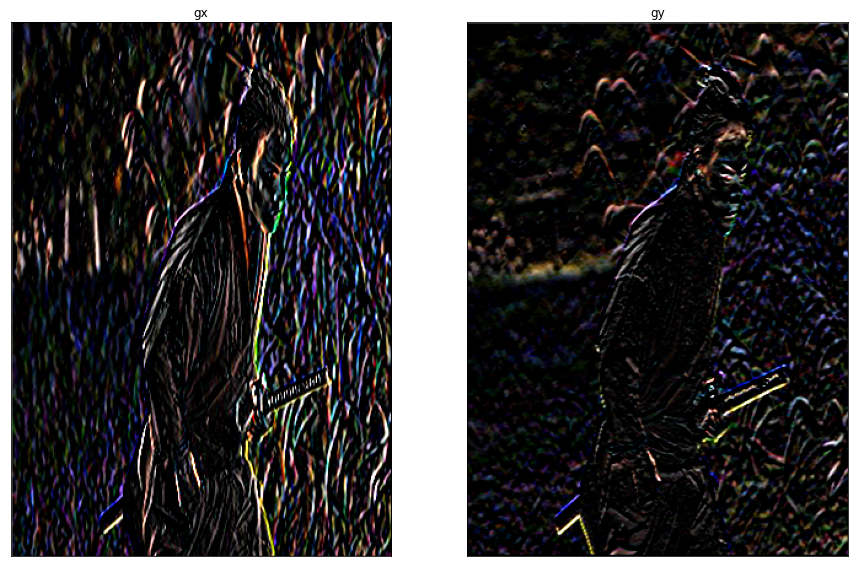

In [110]:
channels = 1
out_channels = 3
dx =  torch.Tensor([
                    [-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]
                   ]).expand(out_channels, channels ,3,3)
dy = torch.Tensor([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]
                  ]).expand(out_channels,channels,3,3)

def get_gradient(img_tensor):
  '''
  img_tensor_batch shape = (batch_size, in_channels , height, width)
  '''
  return F.conv2d(img_tensor, weight=dx, stride=(1,1), groups=3, padding=(1,1)), F.conv2d(img_tensor,dy, stride=(1,1), groups=3, padding=(1,1))

proc_img_tensor = proc_tensor.transpose(1, 3)
proc_img_tensor = proc_img_tensor.transpose(3, 2)
gx, gy = get_gradient(proc_img_tensor/255.0)

gx = gx.transpose(1,3)
gx = gx.transpose(1,2)
gy = gy.transpose(1,3)
gy = gy.transpose(1,2)

titles=['gx', 'gy']
fig = plt.figure(figsize=(15,15))
for ind, img in enumerate([gx,gy]):
  plt.subplot(1, 2, ind+1)
  plt.title(titles[ind])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img.squeeze(), cmap='gray') 


#### Sanity check

Verify the result above vs OpenCV's Sobel operator.

How does openCV Sobel function do it:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img_t torch.Size([1, 3, 310, 435])


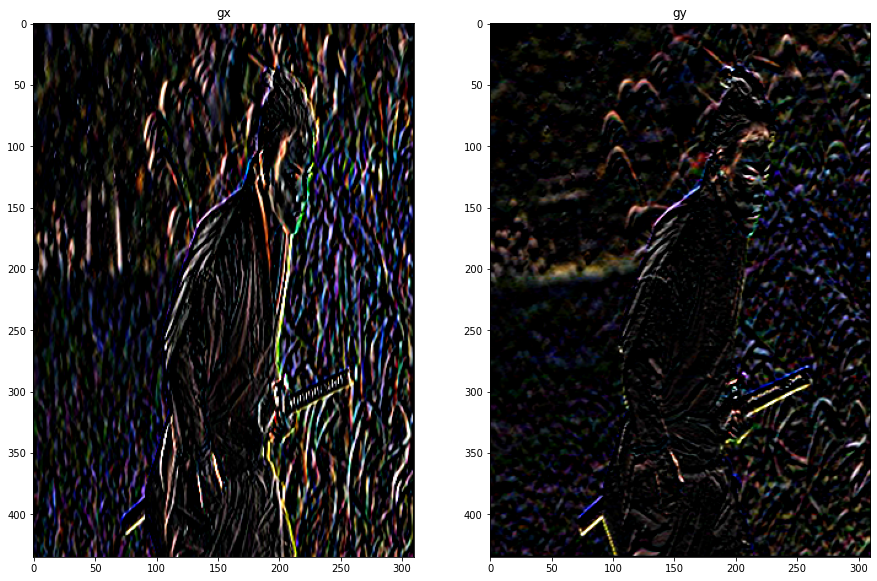

In [111]:
import cv2
img_t = torch.transpose(proc_tensor, 1,3)
print('img_t', img_t.shape)
img_t = img_t.transpose(2,3)
im_t = img_t.squeeze() / 255.0
im_t = im_t.transpose(0, 2)
im_t = im_t.transpose(0, 1)
im_in = im_t.detach().numpy()

gx1 = cv2.Sobel(im_in, cv2.CV_32F, 1, 0, ksize=3)
gy1 = cv2.Sobel(im_in, cv2.CV_32F, 0, 1, ksize=3)
gxt1 = torch.tensor(gx1[:,:,0])
gxt2 = torch.tensor(gx1[:,:,1])

titles=['gx', 'gy']
fig = plt.figure(figsize=(15,15))
for ind, img in enumerate([gx1,gy1]):
  plt.subplot(1, 2, ind+1)
  plt.title(titles[ind])
  plt.imshow(img, cmap='gray') 


After calculating both derivatives in the X, Y directions, we'll calculate the magnitude and direction of each gradient in each pixel, using the following formula

$g=\sqrt{g_x^2 + g_y^2}$

$\theta=\arctan{\frac{g_y}{g_x}}$

Since we have 3 channels, the magnitude $g$ at each pixel will be the max magnitude of the 3 channels, and the direction $\theta$ will be the direction of that max.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


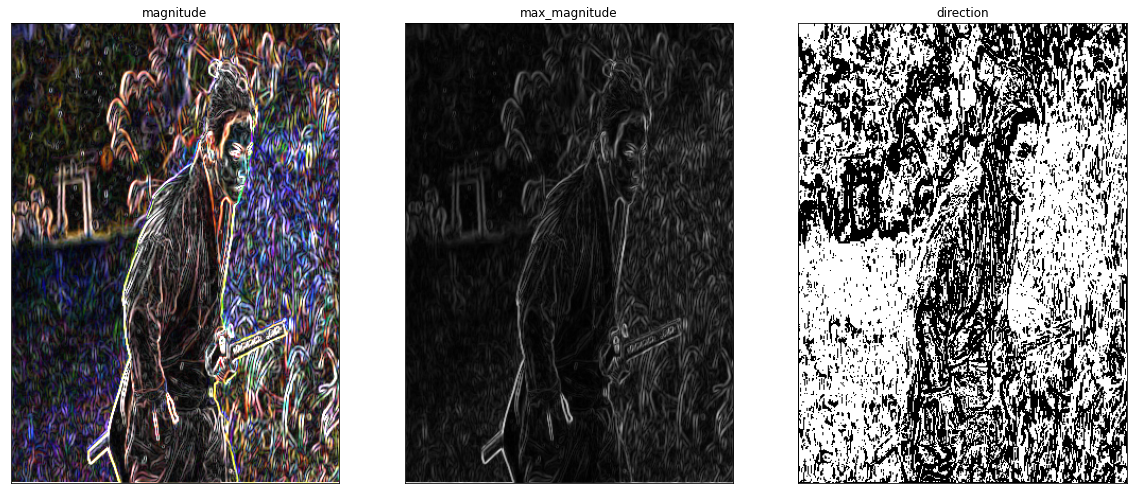

In [112]:
gx_2 = gx ** 2
gy_2 = gy ** 2

# magnitude of all channels
mag_chs = torch.sqrt(gx_2 + gy_2)

# index of channel giving the max magnitude
max_ch_idxs = torch.argmax(mag_chs.squeeze(), dim=2)

magnitude, i = torch.max(mag_chs.squeeze(), dim=2)
epsiln = 1e-10

div1 = (gy.squeeze()+epsiln)/(gx.squeeze()+epsiln) # prevent division by 0
div = div1.transpose(0,2)
direction = torch.atan(div).squeeze()
direction = torch.take(direction, max_ch_idxs) * 180/np.pi

dir360 = (direction + 360) % 360 # make all gradients between 0 - 360 (no negatives)

titles=['magnitude', 'max_magnitude', 'direction']
fig = plt.figure(figsize=(20,20))
for ind, img in enumerate([mag_chs.squeeze(), magnitude, dir360]):
  plt.subplot(1, 3, ind+1)
  plt.title(titles[ind])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img.squeeze(), cmap='gray')


Normalizing the orientations to be within the range $[0, 180]$ (i.e. unsigned gradients)

In [113]:
ori_unsigned = dir360
ori_unsigned[dir360 > 180] =  180 - (360 - dir360[dir360 > 180])
print('ori_unsigned', ori_unsigned.shape, 'max', torch.amax(ori_unsigned), 'min', torch.amin(ori_unsigned))

ori_unsigned torch.Size([435, 310]) max tensor(179.3997) min tensor(44.5538)


In the following section will calculate the histogram of gradients which is the step which (almost) gives the feature vector of the image.

Will segment the image into 8x8 grids and take the histogram of gradients for each grid.

Suppose the image dimensions are 160x80, that's 200 8x8 grids, thus, will use tensor reshape method to convert the image of 160x80 into 8x8x200.

In [114]:
#dividing the image into 8x8s

img_dims = np.array(magnitude.squeeze().shape) % 8

cropped_mag = magnitude.squeeze()[:-img_dims[0]:, :-img_dims[1]:]
cropped_dir = ori_unsigned.squeeze()[:-img_dims[0]:, :-img_dims[1]:]

img_dims = np.array(cropped_mag.squeeze().shape)//8

num_of_grids = img_dims[0] * img_dims[1]
grid_mag = cropped_mag.reshape(8,8, num_of_grids)
grid_dir = cropped_dir.reshape(8,8, num_of_grids)

grid_mag.shape, grid_dir.shape


(torch.Size([8, 8, 2052]), torch.Size([8, 8, 2052]))

### Building histogram

Given 8x8 grid of gradients' magnitudes and orientations, will need to map those to a 1x9 tensor, where each element/bin corresponds to a range of degrees with deltas of $20^{\circ}$.

For each magnitude and its corresponding orientation, we need to know which bins the orientation should fall into.

In [115]:
# building histogram
bins = np.array([20,40,60,80,100,120,140,160,180]).astype(np.float)
num_of_bins = len(bins)
hist = torch.zeros(num_of_bins, num_of_grids)

grid_dir = grid_dir.float()
bin_idxs = grid_dir <= 150
bin_idxs = bin_idxs.nonzero()

xy = bin_idxs[:, :2]
grid_idxs = bin_idxs[:, -1]


# this part is ugly and im trying to find a pytorch way of doing it better,
# by not using python for-loops:
# https://discuss.pytorch.org/t/selecting-indices-from-list-of-indices/129232/2
for bin_id, bin in enumerate(bins):
  curr_bin = torch.zeros_like(grid_dir)
  prev_bin = torch.zeros_like(grid_dir)
  idxs = grid_dir <= bin
  idxs = idxs.nonzero()
  for idx in idxs:
    xyz = idx.unbind()
    orientation = grid_dir[xyz]
    if orientation >= bin - 20:
      curr_bin[xyz] = 10 - abs(orientation - bin)
      prev_bin[xyz] = 10 - abs(orientation - (bin - 20))
  # at this point, `curr_bin` and `prev_bin` has all the elements' conribution ratio
  # to the current and prev bins. Now we need to multiply with the magnitude
  curr_bin = curr_bin * grid_mag
  prev_bin = prev_bin * grid_mag
  
  prev_bin_sum = prev_bin.sum(dim = 1)
  prev_bin_sum = prev_bin_sum.sum(dim = 0)
  hist[bin_id] += prev_bin_sum




### 16x16 Normalizing
At this point `hist` contains the 8x8 histograms, we'll take 4 of those, concatenate them to form 16x16 block, where each block has 9x1 histogram, and now we'll have 36x1 histo, which will be normalized using the L2 method.

In [116]:
# hist is  9 x grids, will reshape it to be 36x(grids/4)
normalized_hist_size = 4 * num_of_bins
features_count = hist.shape[1] // 4
feature_vec = hist.reshape(normalized_hist_size, features_count)
feature_vec.shape

torch.Size([36, 513])

In order to prevent the feature from changing as a result of changes in light intensity, will need to normalize the 36x1 histograms.

$Hist = (h_1, ..., h_{36})$

$ \left\Vert\left(Hist\rm\right) \right\Vert = \left(\sum_{i=1}^{36} h_i^2 \bf\right)$

normalized = $(\frac{h_1}{\left\Vert\left(Hist\rm\right) \right\Vert}, ..., \frac{h_{36}}{\left\Vert\left(Hist\rm\right) \right\Vert})$

In [117]:
n = torch.linalg.norm(feature_vec, dim=0)
expanded_norm = n.reshape(n.shape[0], 1).expand(513,36)
feat_vec = feature_vec.transpose(0,1)
normalized = feat_vec/ expanded_norm


Final step is to create the descriptor vector of the image which is basically the normalized vector from prev step but streached out.

In [118]:
vec = normalized.transpose(0,1)
desc = vec.reshape(1, vec.shape[0] * vec.shape[1])
print('desc.shape', desc.shape)
desc

desc.shape torch.Size([1, 18468])


tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.3947, -0.4023, -0.4611]])